## Analyze A/B Test Results

## By: Mariam Ahmed Amin


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

For this project, I am working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

`1.` Now, read in the `ab_data.csv` data.
a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')

In [3]:
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
# running info method to know if there are null values and to know the data types of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


###### Timestamp, group and landing_page columns are string, and user_id and converted columns are int. There is no null values.

b. Use the cell below to find the number of rows in the dataset.

In [5]:
df.shape[0]

294478

The dataset has 294478 rows

c. The number of unique users in the dataset.

In [6]:
df['user_id'].nunique()

290584

There are 290584 unique user in the dataset


d. The proportion of users converted.

In [7]:
df['converted'].mean()

0.11965919355605512

The proportion of users converted is 0.11965

e. The number of times the `new_page` and `treatment` don't match.

In [8]:
 df[(df["group"]!="treatment")&(df["landing_page"]=="new_page")].shape[0] +  df[(df["group"]=="treatment")&(df["landing_page"]!="new_page")].shape[0]

3893

 The number of times the new_page and treatment don't match is 3893

f. Do any of the rows have missing values?

In [9]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

No, there is no rows having missing values.

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page. 

a. Now we create a new dataset that meets the above specifications.  

In [10]:
df2 = df[((df['group'] == 'treatment') == (df['landing_page'] == 'new_page')) == True]

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

a. How many unique **user_id**s are in **df2**?

In [12]:
df2['user_id'].nunique()

290584

Unique users in df2 = 290584 (the same as df !)

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
df2['user_id'].value_counts().head()

773192    2
630732    1
811737    1
797392    1
795345    1
Name: user_id, dtype: int64

The user_id = 773192 is the repeated one.

c. What is the row information for the repeat **user_id**? 

In [14]:
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. I remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2.drop_duplicates(subset='user_id',inplace=True)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [16]:
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` 

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
df2['converted'].mean()

0.11959708724499628

The probability of an individual converting regardless of the page they receive = 0.11959

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
control = df2[df2['group']=='control']
control_conversion_rate =control['converted'].mean()
control_conversion_rate

0.1203863045004612

Given that an individual was in the control group, the probability they converted = 0.1203

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
treatment = df2[df2['group']=='treatment']
treatment_conversion_rate =treatment['converted'].mean()
treatment_conversion_rate

0.11880806551510564

Given that an individual was in the treatment group, the probability they converted = 0.1188

d. What is the probability that an individual received the new page?

In [20]:
df2[df2['landing_page']=='new_page'].shape[0]/df2.shape[0]

0.5000619442226688

The probability that an individual received the new page = 0.5

e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

###### Through conditional probability, I do not think that there is sufficient evidence that the new treatment page leads to more conversions, because there is no big difference between the probability of converting for both control and treatment groups(0.12 and 0.118).

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

###### The null hypothesis is Pnew<=Pold  and the alternative is Pnew>Pold

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [21]:
p_new = df2['converted'].mean()
p_new

0.11959708724499628

The conversion rate for  𝑝𝑛𝑒𝑤  under the null = 0.11959

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [22]:
p_old = p_new
p_old

0.11959708724499628

The conversion rate for  𝑝𝑜𝑙𝑑  under the null = 0.11959

c. What is $n_{new}$, the number of individuals in the treatment group?

In [23]:
n_new=treatment.shape[0]
n_new

145310

The number of individuals in the treatment group = 145310

d. What is $n_{old}$, the number of individuals in the control group?

In [24]:
n_old=df2.shape[0]-n_new
n_old

145274

The number of individuals in the control group = 145274

e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [25]:
new_page_converted =np.random.choice([1,0], n_new, [p_new, 1-p_new])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [26]:
old_page_converted =np.random.choice([1,0], n_old, [p_old, 1-p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [27]:
# I get the mean because i can not take their difference because they have different length 
# and i get the average using mean instead of calculating 
new_page_converted.mean() -old_page_converted.mean()

0.0003513199706903225

###### It approximately = 0

h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [28]:
p_diffs = []
npc = np.random.binomial(n_new,p_new,10000)/n_new
opc = np.random.binomial(n_old,p_old,10000)/n_old
p_diffs=npc-opc

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

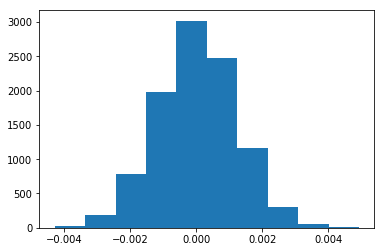

In [29]:
plt.hist(p_diffs);

Yes, it is like what I have expected, it is normally distributed and its mean = 0

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [30]:
actual_diff = treatment['converted'].mean()-control['converted'].mean()
proportion=(p_diffs>actual_diff).mean()
proportion

0.9103

The proportion = 0.9103

k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

###### The proportion of differences which are greater than the actual value is called the p-value, and it equals 0.9103 so we can not reject the null hypothesis because the p-value is greater than 0.05, so there is no difference between the new and old pages.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [31]:
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

convert_old = len(df2[(df2['landing_page']=='old_page')&(df2['converted']==1)])
convert_new = len(df2[(df2['landing_page']=='new_page')&(df2['converted']==1)])
n_old = len(df2[df2['landing_page']=='old_page'])
n_new = len(df2[df2['landing_page']=='new_page'])


/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [32]:
stat, p_value = proportions_ztest(np.array([convert_new,convert_old]),np.array([n_new, n_old]),alternative='larger')

In [33]:
print(stat, p_value)

-1.31092419842 0.905058312759


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

###### Because the p-value equals 0.9103 so we can not reject the null hypothesis because the p-value is greater than 0.05 .Findings in parts j and k agree.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

###### I would use logistic regression since each row is either conversion or no conversion.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [34]:
df2['intercept'] = 1
df2[['temp','ab_page']]= pd.get_dummies(df2['group'])
df2.drop('temp', axis=1, inplace=True)
df2.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#i

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [35]:
# setting the logistic regression model
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [36]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-08-12 18:34 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

###### The P-value associated with ab_page = 0.1899, it differs from one in part II because they have different hypotheses.

For part II:

    The null hypothesis: P_old>=P_new.
    
    The alternative:     P_old<p_new.
    
For part III:

    The null hypothesis: P_old=P_new.
    
    The alternative:     P_old!=P_new.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

###### It is better to consider more factors to be added to the model, that helps to fit the data well so it improves the accuracy. But there is some advantages that we have to be aware about otherwise the model will not be correct. You may face multicollinearility, and this happens when the features of the model are correlated with each other. We overcome it when we let the features not correlated with each other and each selected feature correlated with the target.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [37]:
temp_df = pd.read_csv('countries.csv')
temp_df.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [38]:
# joinig the two datasets
new_df = df2.join(temp_df.set_index('user_id'),on='user_id',how='inner')
new_df.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [39]:
new_df['country'].unique()

array(['US', 'CA', 'UK'], dtype=object)

In [40]:
temp=pd.get_dummies(new_df['country'])
temp.head()

,CA,UK,US
0,0,0,1
1,0,0,1
2,0,0,1
3,0,0,1
4,0,0,1


In [41]:
# adding new columns, I did not add column US because I have selected it as the baseline
new_df[['CA','UK']] = temp[['CA','UK']] 
new_df.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,0


In [42]:
model=sm.Logit(new_df['converted'], new_df[['intercept', 'ab_page', 'CA', 'UK']])
result=model.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-08-12 18:34 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

###### The P-values all are greater than 0.05, so the model still support not rejecting the null hypothesis, so including the country did not affect the result.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [43]:
# adding new columns
new_df['UK_ab_page'] = new_df['UK']*new_df['ab_page']
new_df['CA_ab_page'] = new_df['CA']*new_df['ab_page']
# setting the logistic regression model
log_mod = sm.Logit(new_df['converted'], new_df[['intercept', 'ab_page', 'CA', 'UK', 'CA_ab_page', 'UK_ab_page']])
# fitting the model
result = log_mod.fit()
result.summary2()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-08-12 18:34 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
CA_ab_page   -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
UK_ab_page    0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

###### Because all P-values are greater than 0.05, then the result did not change, the result still support not rejecting the null hypothesis. 

### Conclusion 
I used 3 methods to perform this A/B test:

    1) Simulated the null hypothesis and observed the proportion of differences greater than the actual difference and the proportion(P-value) was greater than 0.05.
    
    2) Calculated the Z score using the built-in function 'proportions_ztest' and it was z score = -1.3109 which is greater than the critical value -1.645.
    
    3) Used a regression model and its P-Values for factors were greater than 0.05.
    
All these methods prove that we should not reject the null hypothesis, so we should not support landing a new page.

In [45]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0